# Temperature Forecast for Berlin

## Business Goal:
Create a short-term temperature forecast.

1. Get and clean the temperature data.

2. Build a baseline model modelling trend and seasonality.

3. Plot and inspect the different components of a time series.

4. Model time dependence of the remainder using an AR model.

5. Compare the statistical output of different AR models.

6. Test the remainder for stationarity.
    
The temperature data are taken from www.ecad.eu.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import pickle
from scipy import stats

import statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

## EDA

Temperature data:

1. Area: Treptow.

2. City: Berlin.

3. Time interval: 1979 till 2021.

In [2]:
weather_data = pd.read_csv('weather_data.txt', skiprows=19, parse_dates=True, skipinitialspace=True
                           #delim_whitespace=True
                          )
weather_data

,SOUID,DATE,TG,Q_TG
0,111448,19790101,-119,0
1,111448,19790102,-93,0
2,111448,19790103,-78,0
3,111448,19790104,-96,0
4,111448,19790105,-99,0
...,...,...,...,...
15336,111448,20201227,16,0
15337,111448,20201228,28,0
15338,111448,20201229,23,0
15339,111448,20201230,25,0


In [3]:
weather_data.dtypes

SOUID    int64
DATE     int64
TG       int64
Q_TG     int64
dtype: object

In [4]:
weather_data['DATE'] = pd.to_datetime(weather_data['DATE'], format='%Y%m%d')

In [5]:
weather_data.dtypes

SOUID             int64
DATE     datetime64[ns]
TG                int64
Q_TG              int64
dtype: object

In [6]:
weather_data =weather_data.set_index(['DATE'])

#### Rename column TG to temperature.

In [7]:
weather_data = weather_data.rename(columns={'TG': 'temperature'})

In [8]:
weather_data

,SOUID,temperature,Q_TG
DATE,,,
1979-01-01,111448,-119,0
1979-01-02,111448,-93,0
1979-01-03,111448,-78,0
1979-01-04,111448,-96,0
1979-01-05,111448,-99,0
...,...,...,...
2020-12-27,111448,16,0
2020-12-28,111448,28,0
2020-12-29,111448,23,0


In [9]:
#weather_data['temperature'] = [(x-32) * 5/9 for x in weather_data['temperature']]
weather_data['temperature']  = weather_data['temperature'] *0.1
weather_data

,SOUID,temperature,Q_TG
DATE,,,
1979-01-01,111448,-11.9,0
1979-01-02,111448,-9.3,0
1979-01-03,111448,-7.8,0
1979-01-04,111448,-9.6,0
1979-01-05,111448,-9.9,0
...,...,...,...
2020-12-27,111448,1.6,0
2020-12-28,111448,2.8,0
2020-12-29,111448,2.3,0


#### Find the missing velues and replace them by interpolating.
Where 9 in Q_TG means there is a missing value.

In [10]:
weather_data[weather_data['Q_TG'] == 9]

,SOUID,temperature,Q_TG
DATE,,,


In [11]:
weather_data['temperature'] = weather_data['temperature']*0.1
weather_data

,SOUID,temperature,Q_TG
DATE,,,
1979-01-01,111448,-1.19,0
1979-01-02,111448,-0.93,0
1979-01-03,111448,-0.78,0
1979-01-04,111448,-0.96,0
1979-01-05,111448,-0.99,0
...,...,...,...
2020-12-27,111448,0.16,0
2020-12-28,111448,0.28,0
2020-12-29,111448,0.23,0


### Feature Engineering

#### Split the data

Last year as test data.

When choosing models, it is common practice to separate the available data into two portions, training and test data, where the training data is used to estimate any parameters of a forecasting method and the test data is used to evaluate its accuracy. Because the test data is not used in determining the forecasts, it should provide a reliable indication of how well the model is likely to forecast on new data.

In [12]:
data_train = weather_data[:-365]

data_test = weather_data[-365:]

##### Feature engineering for test and train data should be performed for this project seperately. For the train data i have created a separate jupyter notebook.

#### Create timestep variable to model the trend using LR

In [13]:
data_train['timestep'] = list(range(len(data_train)))
data_train

<ipython-input-13-aa5978dfbbd7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['timestep'] = list(range(len(data_train)))


,SOUID,temperature,Q_TG,timestep
DATE,,,,
1979-01-01,111448,-1.19,0,0
1979-01-02,111448,-0.93,0,1
1979-01-03,111448,-0.78,0,2
1979-01-04,111448,-0.96,0,3
1979-01-05,111448,-0.99,0,4
...,...,...,...,...
2019-12-28,111448,0.13,0,14971
2019-12-29,111448,0.00,0,14972
2019-12-30,111448,0.45,0,14973


In [14]:
last_train_timestep = data_train['timestep'].max() 

data_test['timestep'] = list(range(last_train_timestep + 1, len(data_test) + last_train_timestep + 1))
data_test.head()

<ipython-input-14-3bbb141a0faf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['timestep'] = list(range(last_train_timestep + 1, len(data_test) + last_train_timestep + 1))


,SOUID,temperature,Q_TG,timestep
DATE,,,,
2020-01-02,111448,0.09,0,14976
2020-01-03,111448,0.46,0,14977
2020-01-04,111448,0.42,0,14978
2020-01-05,111448,0.18,0,14979
2020-01-06,111448,0.49,0,14980


In [15]:
def plot_timeseries (df, title=" ", ylim=True):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    
    df.plot()
    plt.title(title)
    if ylim:
        plt.ylim(ymin=0)
    plt.ylabel("Passengers in 1000s")
    plt.show()

In [16]:
data_train['year'] = data_train.index.year
data_train['month'] = data_train.index.month
data_train['day'] = data_train.index.day
data_train['month_name'] = data_train.index.month_name()

data_train[:40]

<ipython-input-16-32192732ea99>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['year'] = data_train.index.year
<ipython-input-16-32192732ea99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['month'] = data_train.index.month
<ipython-input-16-32192732ea99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,SOUID,temperature,Q_TG,timestep,year,month,day,month_name
DATE,,,,,,,,
1979-01-01,111448,-1.19,0,0,1979,1,1,January
1979-01-02,111448,-0.93,0,1,1979,1,2,January
1979-01-03,111448,-0.78,0,2,1979,1,3,January
1979-01-04,111448,-0.96,0,3,1979,1,4,January
1979-01-05,111448,-0.99,0,4,1979,1,5,January
1979-01-06,111448,-1.27,0,5,1979,1,6,January
1979-01-07,111448,-0.54,0,6,1979,1,7,January
1979-01-08,111448,0.05,0,7,1979,1,8,January
1979-01-09,111448,0.06,0,8,1979,1,9,January


In [17]:
data_test['year'] = data_test.index.year
data_test['month'] = data_test.index.month
data_test['day'] = data_test.index.day
data_test['month_name'] = data_test.index.month_name()

data_test[:40]

<ipython-input-17-a275833fb99e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['year'] = data_test.index.year
<ipython-input-17-a275833fb99e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['month'] = data_test.index.month
<ipython-input-17-a275833fb99e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,SOUID,temperature,Q_TG,timestep,year,month,day,month_name
DATE,,,,,,,,
2020-01-02,111448,0.09,0,14976,2020,1,2,January
2020-01-03,111448,0.46,0,14977,2020,1,3,January
2020-01-04,111448,0.42,0,14978,2020,1,4,January
2020-01-05,111448,0.18,0,14979,2020,1,5,January
2020-01-06,111448,0.49,0,14980,2020,1,6,January
2020-01-07,111448,0.27,0,14981,2020,1,7,January
2020-01-08,111448,0.64,0,14982,2020,1,8,January
2020-01-09,111448,0.84,0,14983,2020,1,9,January
2020-01-10,111448,0.94,0,14984,2020,1,10,January


In [18]:
data_train = pd.get_dummies(data_train[['temperature', 'day','timestep','month', 
                                    'year', 'month_name']], prefix = '', prefix_sep='')

In [19]:
data_test = pd.get_dummies(data_test[['temperature', 'day','timestep','month', 
                                    'year','month_name']], prefix = '', prefix_sep='')

### Additive or multiplicative decomposition?

#### Step 1.

Deciding on whether to do additive or multiplicative decomposition.
Multiplicative: do l need to do log transform?
When to log-transform the target variable?

It is useful, to do a multiplicative decomposition, if and only if the distribution of the target variable is right-skewed which can be observed by a simply histogram plot. This occurs
when there are outliers that can't be filtered out as they are important to the model.

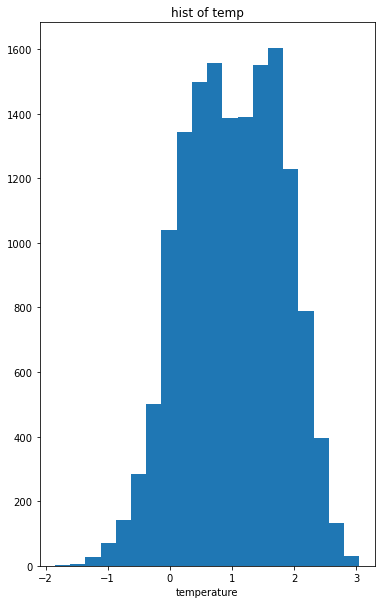

In [20]:
plt.figure(figsize=(6,10))
plt.hist(data_train['temperature'], bins=20)
plt.xlabel("temperature")
plt.title("hist of temp")
plt.show()

<b> Trend </b>

In [21]:
m_trend = LinearRegression()

X = data_train[['timestep']]
y = data_train[['temperature']]

m_trend.fit(X, y)

data_train['trend'] = m_trend.predict(X)

data_train.head()

,temperature,day,timestep,month,year,April,August,December,February,January,July,June,March,May,November,October,September,trend
DATE,,,,,,,,,,,,,,,,,,
1979-01-01,-1.19,1,0,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912025
1979-01-02,-0.93,2,1,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912038
1979-01-03,-0.78,3,2,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912052
1979-01-04,-0.96,4,3,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912065
1979-01-05,-0.99,5,4,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912079


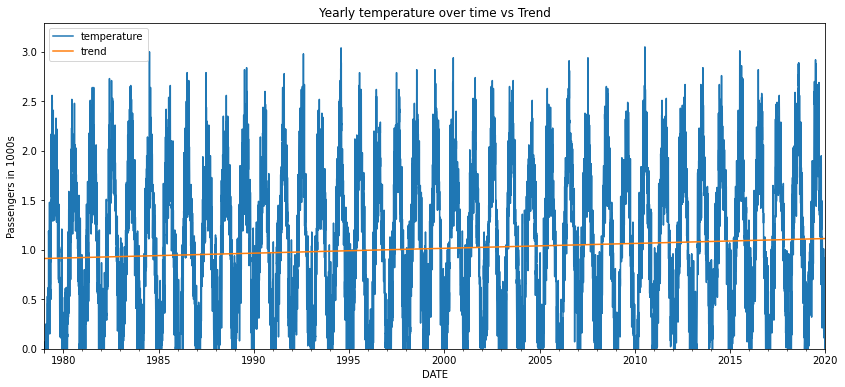

In [22]:
plot_timeseries(data_train[['temperature', 'trend']], title="Yearly temperature over time vs Trend")

For one year.

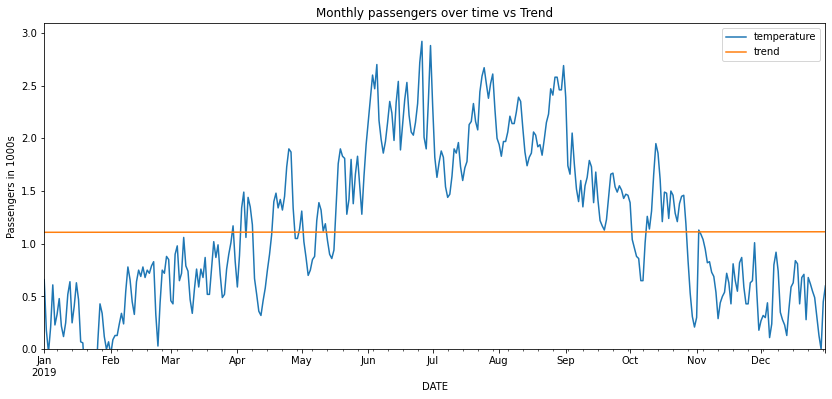

In [23]:
plot_timeseries(data_train[data_train.index.year==2019][['temperature', 'trend']], 
                title="Monthly passengers over time vs Trend")

<b> Seasonality </b>

Above we added new features such as month to show as the seasonality.

In [24]:
data_to_plot = data_train[['year','temperature','April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September']]

<AxesSubplot:xlabel='year', ylabel='temperature'>

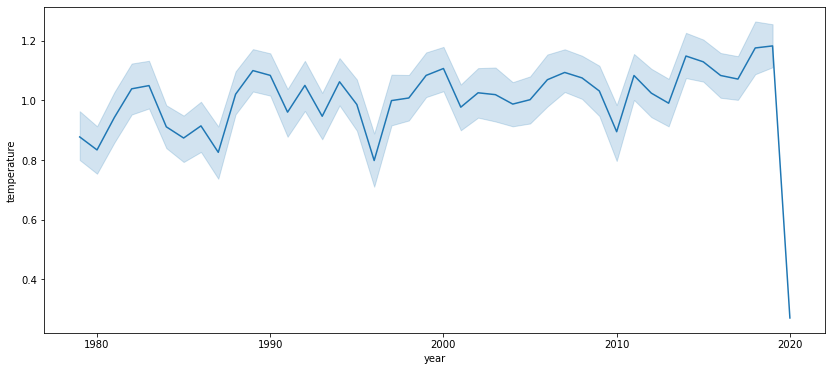

In [25]:
sns.lineplot(data=data_to_plot, x = 'year' ,y = 'temperature')

Save data from 1979 till 2020 for later use.

In [26]:
data_train.copy()

,temperature,day,timestep,month,year,April,August,December,February,January,July,June,March,May,November,October,September,trend
DATE,,,,,,,,,,,,,,,,,,
1979-01-01,-1.19,1,0,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912025
1979-01-02,-0.93,2,1,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912038
1979-01-03,-0.78,3,2,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912052
1979-01-04,-0.96,4,3,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912065
1979-01-05,-0.99,5,4,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,0.13,28,14971,12,2019,0,0,1,0,0,0,0,0,0,0,0,0,1.113676
2019-12-29,0.00,29,14972,12,2019,0,0,1,0,0,0,0,0,0,0,0,0,1.113689
2019-12-30,0.45,30,14973,12,2019,0,0,1,0,0,0,0,0,0,0,0,0,1.113703


<AxesSubplot:xlabel='DATE'>

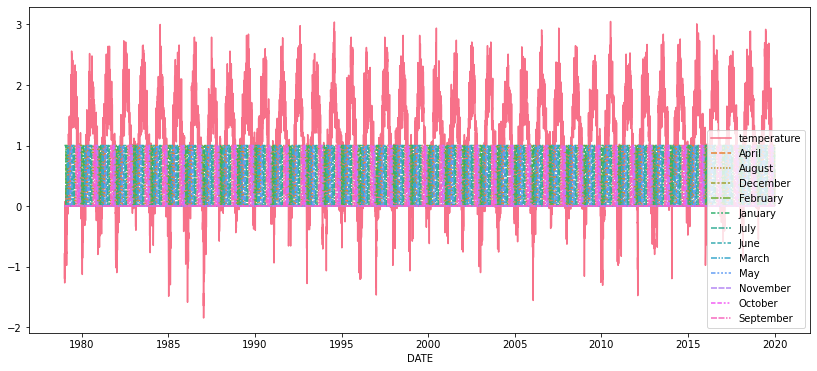

In [27]:
weather_data_all_years = data_train[['temperature','April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September']]
sns.lineplot(data=weather_data_all_years)

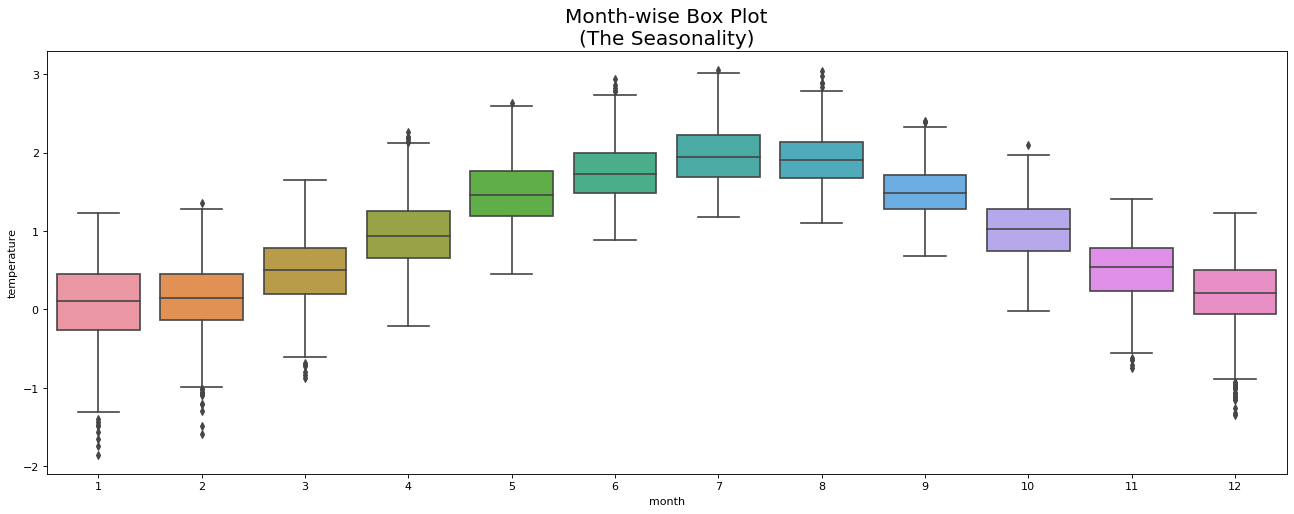

In [28]:
#data_train_2019 = data_train[data_train["year"] == 2019]
fig, axes = plt.subplots(1, figsize=(20,7), dpi= 80)

sns.boxplot(x='month', y='temperature', data=data_train.loc[~data_train.year.isin([2015, 2019]), :])

axes.set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

<b> Additive or multiplicative. </b> 

Step 2.

In specifically looking at your data, because the seasonality varies, i.e., seasonality at the beginning is large and as it seasonality is almost not present in the later years, this would suggest a multiplicative decomposition.
Here we look the last 5 years.

<AxesSubplot:xlabel='DATE'>

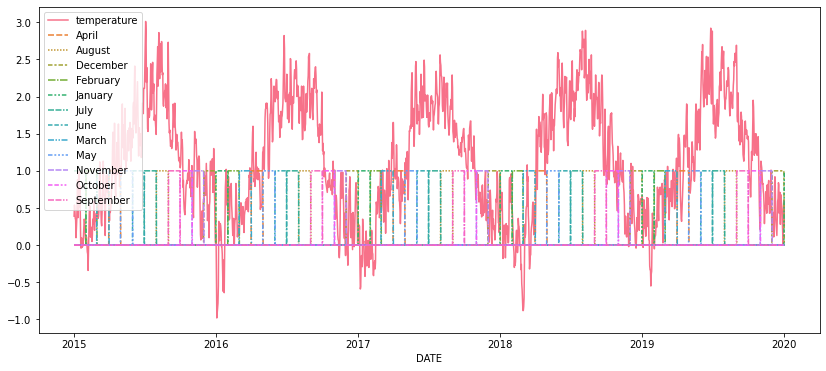

In [29]:
weather_data_from_2015 = data_train[data_train["year"] > 2014]

weather_data = weather_data_from_2015[['temperature','April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September']]
sns.lineplot(data=weather_data)

Step 3.

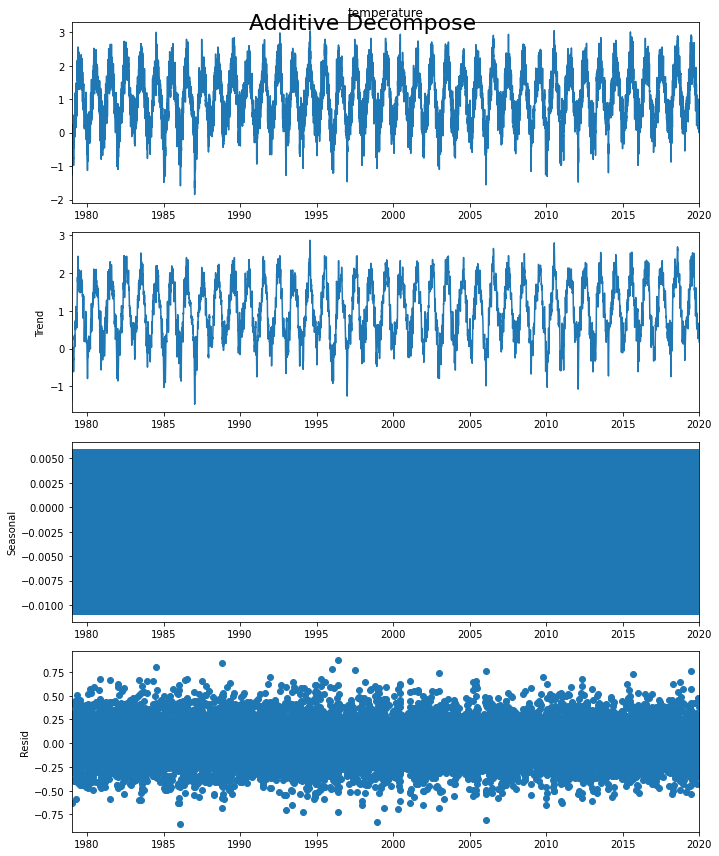

DATE
1979-01-01   -1.19
1979-01-02   -0.93
1979-01-03   -0.78
1979-01-04   -0.96
1979-01-05   -0.99
              ... 
2019-12-28    0.13
2019-12-29    0.00
2019-12-30    0.45
2019-12-31    0.60
2020-01-01    0.27
Name: temperature, Length: 14976, dtype: float64

In [30]:
# Multiplicative Decomposition
#result_mul = seasonal_decompose(data_train['temperature'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(data_train['temperature'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,12)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

result_add.trend
result_add.seasonal
result_add.resid
result_add.observed

### Conclusion.

Seasonal_decompose for multiplicative model from stats model, didn't work for these data. A try resulted to the following error:

ValueError: Multiplicative seasonality is not appropriate for zero and negative values
    
From the above steps we conclude that an additive model is the appropriate for our data.

#### Do a lot of plots to all the steps of the implementation to find time dependencies. Stationarity (mean 0 and constant and standard deviation).

In [31]:
# now we fit another model that captures both trend and seasonality
X = data_train.drop(['trend','temperature', 'year'], axis=1)
y = data_train['temperature']

m_trend_seasonal = LinearRegression()

m_trend_seasonal.fit(X, y)

data_train['trend_seasonal'] = m_trend_seasonal.predict(X)

data_train.head()

,temperature,day,timestep,month,year,April,August,December,February,January,July,June,March,May,November,October,September,trend,trend_seasonal
DATE,,,,,,,,,,,,,,,,,,,
1979-01-01,-1.19,1,0,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912025,-0.019755
1979-01-02,-0.93,2,1,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912038,-0.019948
1979-01-03,-0.78,3,2,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912052,-0.020141
1979-01-04,-0.96,4,3,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912065,-0.020334
1979-01-05,-0.99,5,4,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,0.912079,-0.020527


In [32]:
X_test = data_test.drop(['temperature', 'year'], axis=1)
X_test

,day,timestep,month,April,August,December,February,January,July,June,March,May,November,October,September
DATE,,,,,,,,,,,,,,,
2020-01-02,2,14976,1,0,0,0,0,1,0,0,0,0,0,0,0
2020-01-03,3,14977,1,0,0,0,0,1,0,0,0,0,0,0,0
2020-01-04,4,14978,1,0,0,0,0,1,0,0,0,0,0,0,0
2020-01-05,5,14979,1,0,0,0,0,1,0,0,0,0,0,0,0
2020-01-06,6,14980,1,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,27,15336,12,0,0,1,0,0,0,0,0,0,0,0,0
2020-12-28,28,15337,12,0,0,1,0,0,0,0,0,0,0,0,0
2020-12-29,29,15338,12,0,0,1,0,0,0,0,0,0,0,0,0


In [33]:
data_test['trend_seasonal'] = m_trend_seasonal.predict(X_test)

data_test.head()

,temperature,day,timestep,month,year,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal
DATE,,,,,,,,,,,,,,,,,,
2020-01-02,0.09,2,14976,1,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169606
2020-01-03,0.46,3,14977,1,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169413
2020-01-04,0.42,4,14978,1,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169220
2020-01-05,0.18,5,14979,1,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169028
2020-01-06,0.49,6,14980,1,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.168835


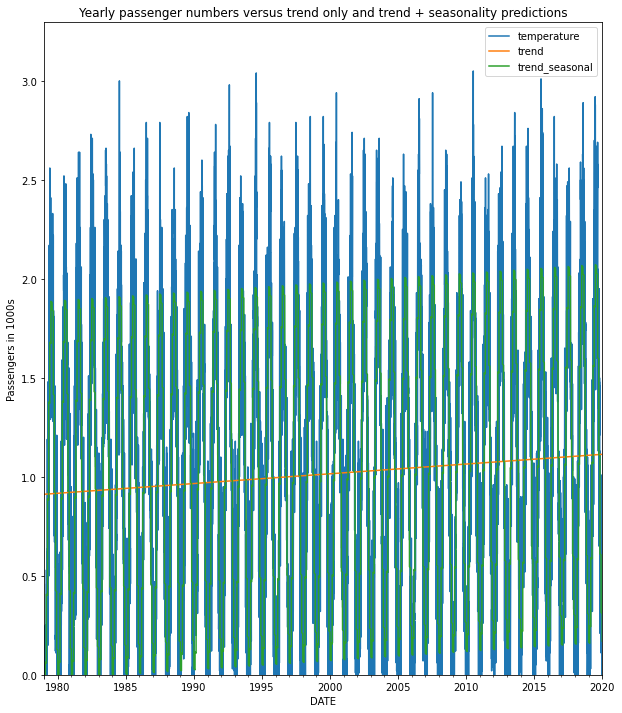

In [34]:
plot_timeseries(data_train[['temperature', 'trend', 'trend_seasonal']], 
                title = 'Yearly passenger numbers versus trend only and trend + seasonality predictions')

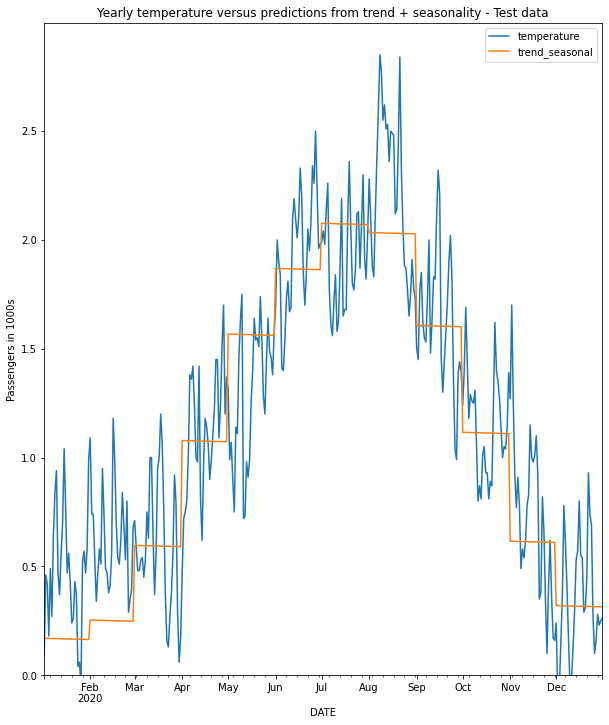

In [35]:
# plot
plot_timeseries(data_test[['temperature', 'trend_seasonal']], 
                title="Yearly temperature versus predictions from trend + seasonality - Test data")

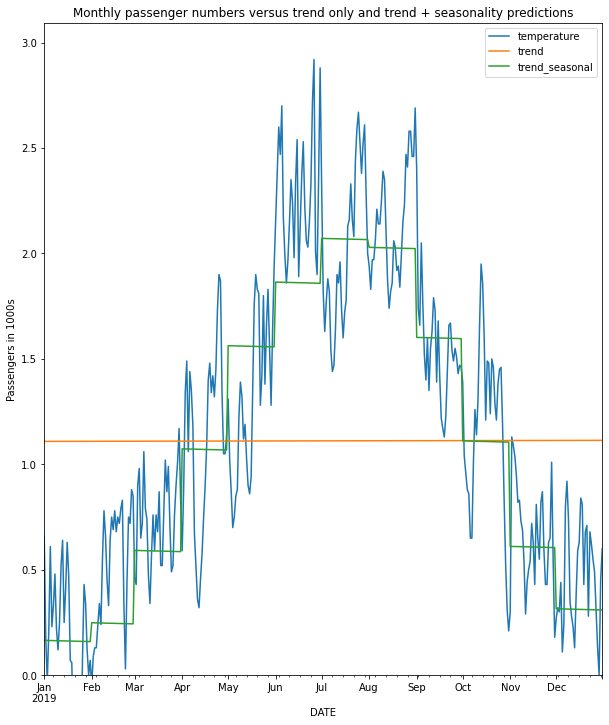

In [36]:
data_train_2019 = data_train[data_train["year"] == 2019]
plot_timeseries(data_train_2019[['temperature', 'trend', 'trend_seasonal']], 
                title = 'Monthly passenger numbers versus trend only and trend + seasonality predictions')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

<AxesSubplot:ylabel='Density'>

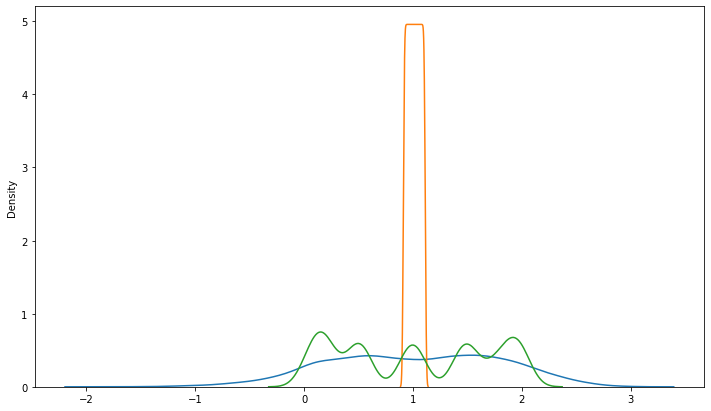

In [37]:
plt.figure(figsize=(12,7))
temp = data_train[['temperature']]
trend = data_train[['trend']]
trend_seas = data_train[['trend_seasonal']]

sns.distplot(temp, hist = False, kde = True,label='sd=3')
sns.distplot(trend, hist = False, kde = True, label='sd=2')
sns.distplot(trend_seas, hist = False, kde = True,label='sd=5')

<b> Remainder. </b>

In [38]:
data_train['remainder'] = data_train['temperature'] - data_train['trend_seasonal']

<AxesSubplot:xlabel='DATE'>

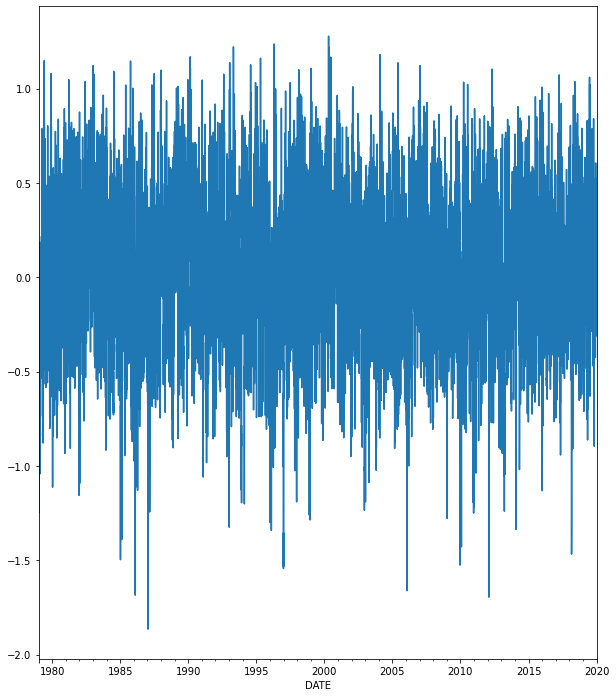

In [39]:
data_train['remainder'].plot()

In [40]:
data_test['remainder'] = data_test['temperature'] - data_test['trend_seasonal']


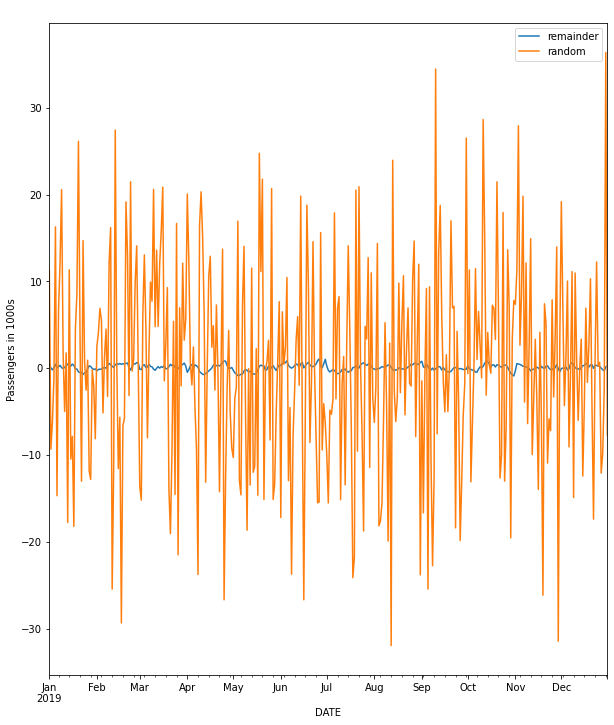

In [41]:
# plot and compare with a random signal
data_train['random'] = np.random.normal(loc=0, scale=12, size=data_train.shape[0])
plot_timeseries(data_train[data_train["year"] == 2019][['remainder', 'random']], ylim=False)

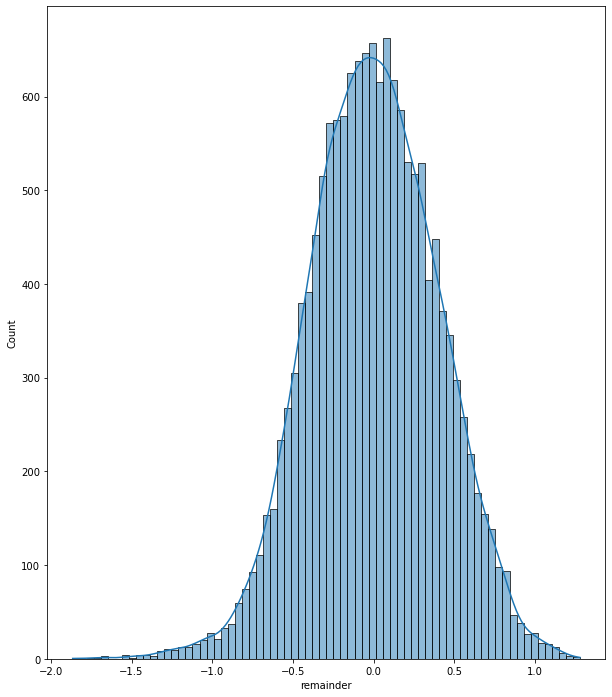

In [42]:
sns.histplot(data_train['remainder'], kde=True);

Do the same for the last 5 years.

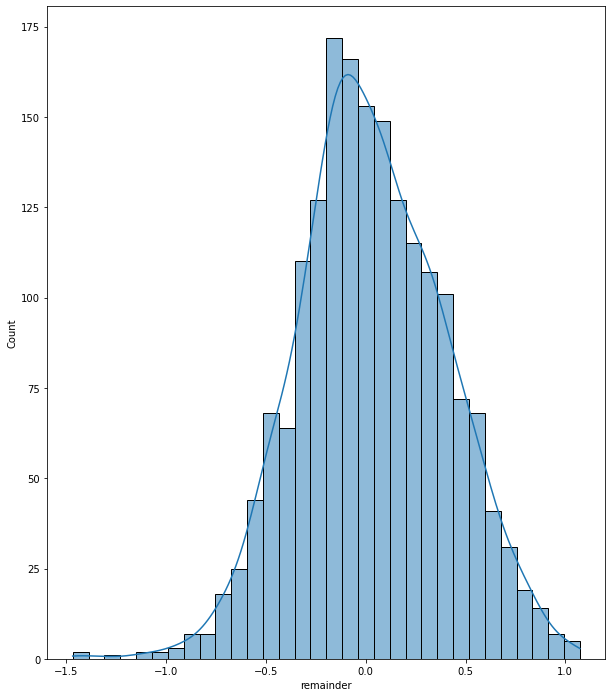

In [43]:
weather_data_from_2015 = data_train[data_train["year"] > 2014]

sns.histplot(weather_data_from_2015['remainder'], kde=True);

<b> Stationarity </b>

On the noise, plot to see if the data are normally distributed and then perform Dickey Fueller test. At the end check the mean and variance of small time intervals.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

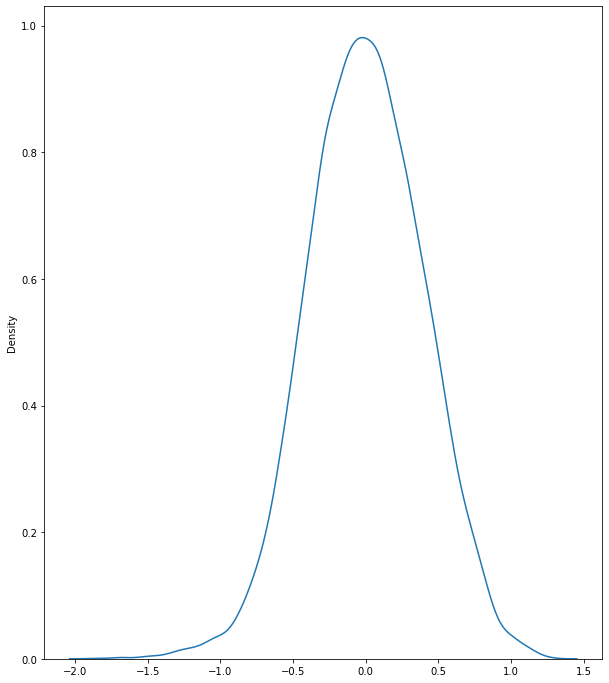

In [44]:
remainder = data_train[['remainder']]
sns.distplot(remainder, hist = False, kde = True,label='sd=3')

In [45]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""   
            adf: {round(adf_stats,2)}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            {round(levels['1%'],2)} (p=1; CI=99%) 
            {round(levels['5%'],2)} (p=5; CI=95%)
            {round(levels['10%'],2)} (p=10 CI=90%) 
            information criterion (AIC): {information_criterion}
            """)



In [46]:
print_adf(data_train['remainder'])

   
            adf: -35.89
            p: 0.0 
            used lag: 3 
            number of observations: 14972
            -3.43 (p=1; CI=99%) 
            -2.86 (p=5; CI=95%)
            -2.57 (p=10 CI=90%) 
            information criterion (AIC): -1549.3297776397958
            




The first number is the ADF-Stats, the more negative it is, the more confident we are that we don't have a random walk.

In the lookup table (dictionary), the smallest value is -3.44 for the adf_stats. Hence, we can reject the null hypothesis with a confidence level of more than 99% (p=0.01, highly significant result).



#TODO: A function for calculating the mean and variance of different time intervals.

In [47]:
data_2019 = data_train[data_train.index.year==2019]

In [48]:
data_2019['remainder'].mean()

0.0764625043918849

In [49]:
three_months = data_2019[['January', 'February', 'March', 'remainder']]
three_months['remainder'].mean()

0.0764625043918849

In [50]:
months_three = data_2019[['October', 'November', 'December', 'remainder']]
months_three['remainder'].mean()

0.0764625043918849

In [51]:
data_2019['remainder'].var()

0.12352084704487855

In [52]:
three_months['remainder'].var()

0.12352084704487855

In [53]:
months_three['remainder'].var()

0.12352084704487855

<b> Saving the test data.</b>

In [54]:
pickle.dump(data_test, open('data_test.pkl', 'wb'))